In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210528'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01, 10.86it/s]


(635090, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(632528, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '구로구'
target_dong = '오류동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(151, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
95348,서울특별시 구로구 오류동 81-201,경인로15나길 20,양지마을,33.46,23.82,23200,3,2018.0,2.0,2020-12-03,693.365212,3.0,연립다세대,대,1534.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동
95379,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,41.59,24.62,21000,6,2019.0,1.0,2020-02-11,504.929069,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동
95380,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,37.01,21.90,21000,6,2019.0,1.0,2020-02-11,567.414212,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동
95381,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,51.15,30.27,25000,7,2019.0,1.0,2020-02-11,488.758553,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동
95382,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,43.53,25.70,22000,3,2019.0,2.0,2021-01-26,505.398576,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(151, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
95348,서울특별시 구로구 오류동 81-201,경인로15나길 20,양지마을,33.46,23.82,23200,3,2018.0,2.0,2020-12-03,693.365212,3.0,연립다세대,대,1534.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,707.820426,2021-03-01
95379,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,41.59,24.62,21000,6,2019.0,1.0,2020-02-11,504.929069,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,566.205051,2021-03-01
95380,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,37.01,21.90,21000,6,2019.0,1.0,2020-02-11,567.414212,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,636.273118,2021-03-01
95381,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,51.15,30.27,25000,7,2019.0,1.0,2020-02-11,488.758553,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,548.072152,2021-03-01
95382,서울특별시 구로구 오류동 81-225,고척로1길 57,연세중앙팰리스,43.53,25.70,22000,3,2019.0,2.0,2021-01-26,505.398576,2.0,연립다세대,대,213.0,제3종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,509.277985,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 구로구 오류동 14-360,디온빌,2.0,47.86,2019-12-13,28500,595.486837,2021-03-01,676.039996,제2종일반주거지역,연립다세대
1,서울특별시 구로구 오류동 14-360,디온빌,2.0,54.00,2019-12-13,32000,592.592593,2021-03-01,672.754240,제2종일반주거지역,연립다세대
2,서울특별시 구로구 오류동 14-360,디온빌,2.0,54.52,2019-12-13,31900,585.106383,2021-03-01,664.255350,제2종일반주거지역,연립다세대
3,서울특별시 구로구 오류동 14-360,디온빌,2.0,29.36,2019-12-13,19600,667.574932,2021-03-01,757.879649,제2종일반주거지역,연립다세대
4,서울특별시 구로구 오류동 14-360,디온빌,2.0,54.52,2019-12-13,32300,592.443140,2021-03-01,672.584571,제2종일반주거지역,연립다세대


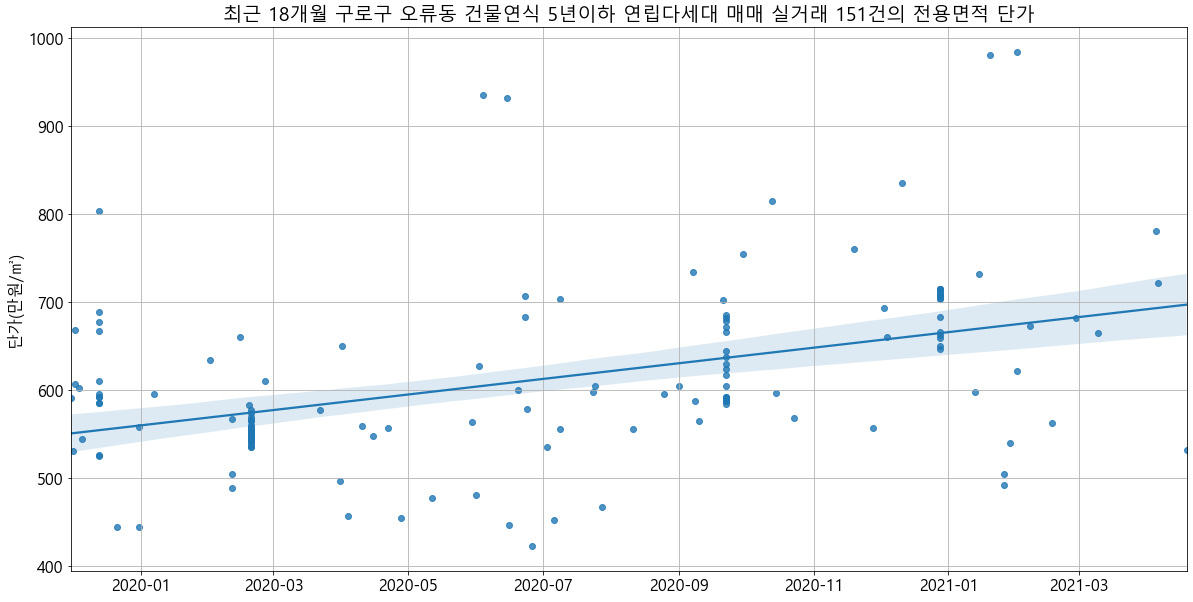

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

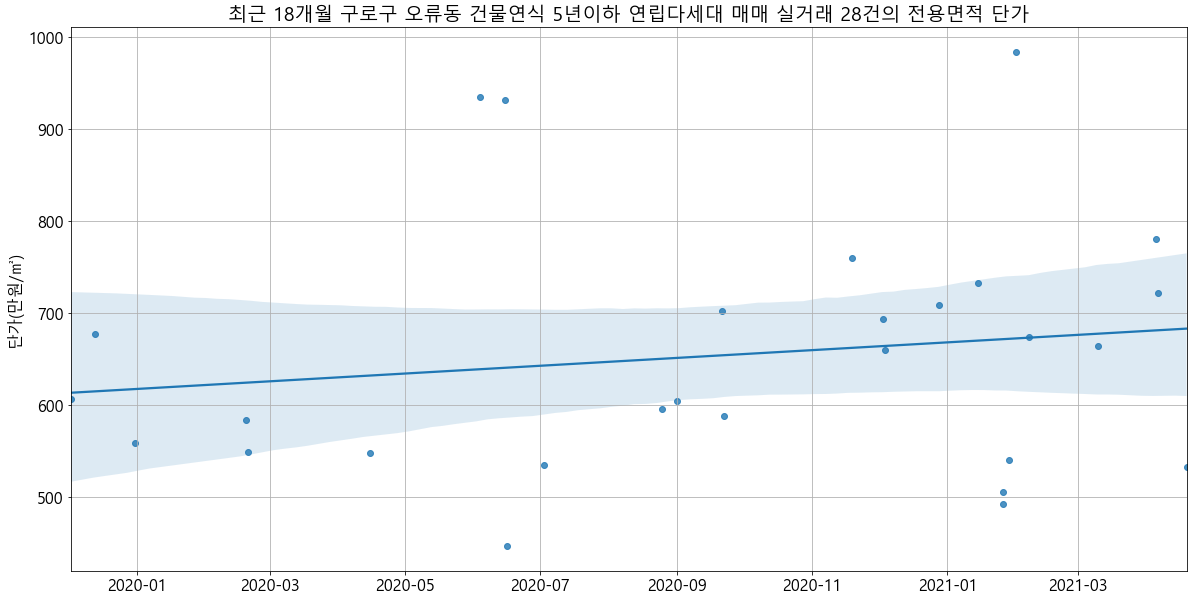

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1196, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
94776,서울특별시 구로구 오류동 81-80,경인로11길 2-5,(81-80),63.11,45.91,13100,2,2004.0,2.0,2006-11-19,207.574077,17.0,연립다세대,대,66.0,제3종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로각지(불),구로구,오류동
94777,서울특별시 구로구 오류동 81-80,경인로11길 2-5,(81-80),63.11,45.91,14000,3,2004.0,4.0,2008-01-29,221.834891,17.0,연립다세대,대,66.0,제3종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로각지(불),구로구,오류동
94784,서울특별시 구로구 오류동 18-3,고척로10길 7-16,LG베스트빌,43.94,27.40,8000,2,2004.0,2.0,2006-03-30,182.066454,17.0,연립다세대,대,177.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),구로구,오류동
94785,서울특별시 구로구 오류동 18-3,고척로10길 7-16,LG베스트빌,43.94,27.40,8000,3,2004.0,2.0,2006-04-18,182.066454,17.0,연립다세대,대,177.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),구로구,오류동
94786,서울특별시 구로구 오류동 18-3,고척로10길 7-16,LG베스트빌,40.04,24.97,8000,4,2004.0,2.0,2006-04-21,199.800200,17.0,연립다세대,대,177.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),구로구,오류동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'구로구 오류동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 1196건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

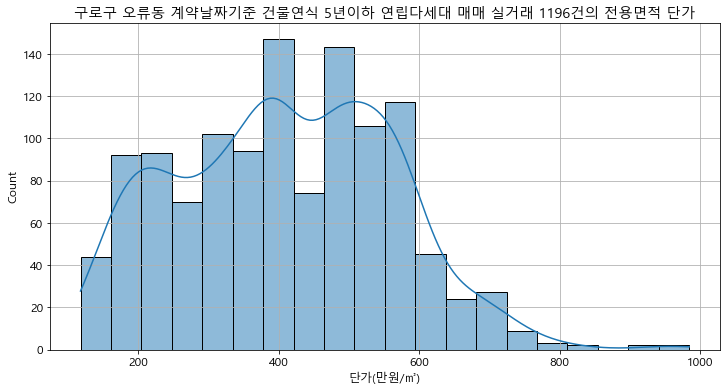

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(531, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 구로구 오류동 1-134,경인로15길 116-4,대하쉐르빌타운1동,59.92,34.84,19500,3,2002.0,4.0,2006-04-22,325.433912,19.0,연립다세대,대,348.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,769.621643,2021-03-01,325.433912,769.621643
1,서울특별시 구로구 오류동 1-146,고척로3길 102,대하쉐르빌타운5동,53.65,29.59,6300,1,2002.0,4.0,2006-04-15,117.427773,19.0,연립다세대,대,280.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,277.706017,2021-03-01,196.305614,382.522743
2,서울특별시 구로구 오류동 1-146,고척로3길 102,대하쉐르빌타운5동,59.96,33.07,16500,1,2002.0,5.0,2007-04-13,275.183456,19.0,연립다세대,대,280.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,487.339470,2021-03-01,196.305614,382.522743
3,서울특별시 구로구 오류동 1-147,고척로3길 104,대하쉐르빌타운3동,56.20,30.75,11000,4,2002.0,5.0,2007-07-26,195.729537,19.0,연립다세대,대,275.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),구로구,오류동,325.061569,2021-03-01,195.729537,325.061569
4,서울특별시 구로구 오류동 1-148,고척로3길 106,대하쉐르빌타운2동,53.65,28.68,13000,2,2002.0,5.0,2007-03-15,242.311277,19.0,연립다세대,대,275.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,441.471279,2021-03-01,198.097564,363.232364


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(194, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 구로구 오류동 1-134,경인로15길 116-4,대하쉐르빌타운1동,59.920,34.84,19500,3,2002.0,4.0,2006-04-22,325.433912,19.0,연립다세대,대,348.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,769.621643,2021-03-01,325.433912,769.621643
2,서울특별시 구로구 오류동 1-146,고척로3길 102,대하쉐르빌타운5동,59.960,33.07,16500,1,2002.0,5.0,2007-04-13,275.183456,19.0,연립다세대,대,280.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,487.339470,2021-03-01,196.305614,382.522743
3,서울특별시 구로구 오류동 1-147,고척로3길 104,대하쉐르빌타운3동,56.200,30.75,11000,4,2002.0,5.0,2007-07-26,195.729537,19.0,연립다세대,대,275.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),구로구,오류동,325.061569,2021-03-01,195.729537,325.061569
6,서울특별시 구로구 오류동 1-148,고척로3길 106,대하쉐르빌타운2동,59.960,32.06,11500,1,2002.0,5.0,2007-09-02,191.794530,19.0,연립다세대,대,275.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,309.416082,2021-03-01,198.097564,363.232364
9,서울특별시 구로구 오류동 1-17,고척로3길 109,영성빌라(1-17),67.050,36.48,27000,4,2003.0,5.0,2008-05-15,402.684564,18.0,연립다세대,대,126.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),구로구,오류동,520.236306,2021-03-01,268.816669,416.104516
11,서울특별시 구로구 오류동 1-6,고척로3길 98-5,대하쉐르빌타운6동,49.440,37.17,13700,2,2002.0,5.0,2007-11-20,277.103560,19.0,연립다세대,대,445.0,제1종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로한면(가),구로구,오류동,427.217349,2021-03-01,254.641393,394.653018
12,서울특별시 구로구 오류동 108-41,경인로2길 48,수목원아트빌(가동),74.820,48.38,20500,5,2006.0,4.0,2010-03-13,273.990912,15.0,연립다세대,대,387.0,제2종일반주거지역,지정되지않음,주거기타,완경사,가로장방,세로한면(가),구로구,오류동,360.403872,2021-03-01,273.990912,360.403872
16,서울특별시 구로구 오류동 108-96,경인로2길 52,수목원아트빌(나동),69.240,42.46,16000,2,2006.0,1.0,2007-07-27,231.080300,15.0,연립다세대,대,328.0,제2종일반주거지역,지정되지않음,주거기타,완경사,역삼각형,세로한면(가),구로구,오류동,383.771025,2021-03-01,204.773166,312.340934
18,서울특별시 구로구 오류동 11-28,고척로4길 15-20,경진주택-가동,64.750,36.86,13300,3,2002.0,4.0,2006-11-06,205.405405,19.0,연립다세대,대,246.0,제3종일반주거지역,지정되지않음,다세대,평지,부정형,세로한면(가),구로구,오류동,399.599817,2021-03-01,196.230574,370.200021
19,서울특별시 구로구 오류동 11-29,고척로4길 15-18,경진주택-나동,57.900,29.56,14000,2,2002.0,4.0,2006-04-20,241.796200,19.0,연립다세대,대,253.0,제3종일반주거지역,지정되지않음,다세대,평지,부정형,세로한면(가),구로구,오류동,571.826052,2021-03-01,241.796200,571.826052


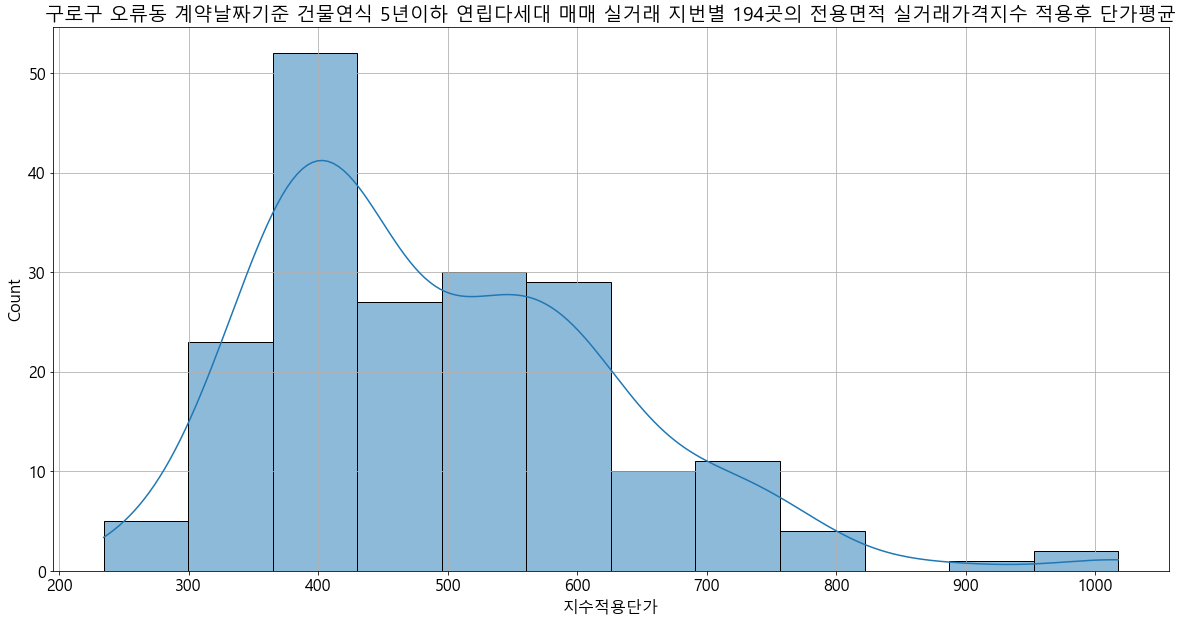

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 구로구 오류동 1-134,대하쉐르빌타운1동,2002.0,59.92,2006-04-22,325.433912,2021-03-01,769.621643,제1종일반주거지역,연립다세대
1,서울특별시 구로구 오류동 1-146,대하쉐르빌타운5동,2002.0,59.96,2007-04-13,275.183456,2021-03-01,487.339470,제1종일반주거지역,연립다세대
2,서울특별시 구로구 오류동 1-147,대하쉐르빌타운3동,2002.0,56.20,2007-07-26,195.729537,2021-03-01,325.061569,제1종일반주거지역,연립다세대
3,서울특별시 구로구 오류동 1-148,대하쉐르빌타운2동,2002.0,59.96,2007-09-02,191.794530,2021-03-01,309.416082,제1종일반주거지역,연립다세대
4,서울특별시 구로구 오류동 1-17,영성빌라(1-17),2003.0,67.05,2008-05-15,402.684564,2021-03-01,520.236306,제2종일반주거지역,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)